### Importazione librerie

In [1]:
import ccxt
import pandas as pd
from datetime import datetime
import time
import numpy as np
import matplotlib.pyplot as plt

### Scaricamento dati

In [2]:
def fetch_crypto_data(market, timeframe, symbols, start_date, end_date):
    # Configura l'exchange
    try:
        exchange = getattr(ccxt, market)()
        exchange.load_markets()
        print(f"[INFO] Collegato all'exchange {market}.")
    except Exception as e:
        print(f"[ERROR] Errore nella connessione all'exchange {market}: {e}")
        return

    # Trasforma le date in timestamp
    try:
        start_timestamp = int(pd.Timestamp(start_date).timestamp() * 1000)
        end_timestamp = int(pd.Timestamp(end_date).timestamp() * 1000)
        print(f"[INFO] Periodo scelto: da {start_date} a {end_date}.")
    except Exception as e:
        print(f"[ERROR] Errore nella conversione delle date: {e}")
        return

    # Lista per i dati scaricati
    all_data = {}

    for symbol in symbols:
        pair = f"{symbol}/USDT"
        if pair not in exchange.symbols:
            print(f"[WARNING] {pair} non è disponibile su {market}.")
            continue

        print(f"[INFO] Inizio il download dei dati per {pair} con timeframe {timeframe}.")

        ohlcv = []
        since = start_timestamp

        # Scarica i dati in blocchi
        while since < end_timestamp:
            try:
                batch = exchange.fetch_ohlcv(pair, timeframe, since)
                if not batch:
                    print(f"[INFO] Nessun dato aggiuntivo trovato per {pair}.")
                    break
                ohlcv.extend(batch)
                since = batch[-1][0] + 1  # Avanza al prossimo blocco
                print(f"[INFO] Scaricati {len(batch)} record per {pair} (fino a {datetime.utcfromtimestamp(batch[-1][0] / 1000)}).")
                time.sleep(exchange.rateLimit / 1000)  # Rispetta il rate limit
            except Exception as e:
                print(f"[ERROR] Errore durante il download dei dati per {pair}: {e}")
                break

        if not ohlcv:
            print(f"[WARNING] Nessun dato trovato per {pair}.")
            continue

        # Crea un DataFrame dai dati
        df = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
        df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
        df.set_index('timestamp', inplace=True)
        all_data[pair] = df
        print(f"[INFO] Dati per {pair} scaricati con successo.")

    print("[INFO] Download completato.")
    return all_data

In [3]:
# Esempio di utilizzo
market_name = "bybit"  # Exchange
timeframe_download = '1d'  # Timeframe (ad esempio: '1m', '1h', '1d')
symbols_list = ['BTC', 'ETH', 'SOL', 'ATH']  # Lista delle criptovalute
start_date = '2024-10-01'  # Data di inizio
end_date = '2024-12-25'  # Data di fine

crypto_data = fetch_crypto_data(market_name, timeframe_download, symbols_list, start_date, end_date)
crypto_data

[INFO] Collegato all'exchange bybit.
[INFO] Periodo scelto: da 2024-10-01 a 2024-12-25.
[INFO] Inizio il download dei dati per BTC/USDT con timeframe 1d.
[INFO] Scaricati 90 record per BTC/USDT (fino a 2024-12-29 00:00:00).
[INFO] Dati per BTC/USDT scaricati con successo.
[INFO] Inizio il download dei dati per ETH/USDT con timeframe 1d.
[INFO] Scaricati 90 record per ETH/USDT (fino a 2024-12-29 00:00:00).
[INFO] Dati per ETH/USDT scaricati con successo.
[INFO] Inizio il download dei dati per SOL/USDT con timeframe 1d.
[INFO] Scaricati 90 record per SOL/USDT (fino a 2024-12-29 00:00:00).
[INFO] Dati per SOL/USDT scaricati con successo.
[INFO] Inizio il download dei dati per ATH/USDT con timeframe 1d.
[INFO] Scaricati 90 record per ATH/USDT (fino a 2024-12-29 00:00:00).
[INFO] Dati per ATH/USDT scaricati con successo.
[INFO] Download completato.


{'BTC/USDT':                 open      high       low     close        volume
 timestamp                                                       
 2024-10-01  63309.05  64127.88  60159.92  60812.41  34614.967726
 2024-10-02  60812.41  62400.00  59974.60  60643.07  24433.166809
 2024-10-03  60643.07  61485.54  59861.28  60756.13  26729.110701
 2024-10-04  60756.13  62486.35  60458.93  62090.14  23662.217058
 2024-10-05  62090.14  62382.03  61680.63  62059.37   8936.861444
 ...              ...       ...       ...       ...           ...
 2024-12-25  98671.43  99601.85  97629.66  99440.87  20945.333020
 2024-12-26  99440.87  99980.75  95194.00  95783.86  25072.760176
 2024-12-27  95783.86  97547.24  93481.23  94300.45  24918.439096
 2024-12-28  94300.45  95738.60  94127.01  95298.41  13175.275667
 2024-12-29  95298.41  95342.70  94805.21  94964.37   5598.661725
 
 [90 rows x 5 columns],
 'ETH/USDT':                open     high      low    close        volume
 timestamp                    

In [4]:
dati = pd.DataFrame({'Timestamp': crypto_data[symbols_list[0] + '/USDT'].index})
for crypto in symbols_list:
    dati[crypto] = crypto_data[crypto + '/USDT']['close'].values
    
dati

,Timestamp,BTC,ETH,SOL,ATH
0,2024-10-01,60812.41,2447.95,145.13,0.058261
1,2024-10-02,60643.07,2364.01,140.18,0.056709
2,2024-10-03,60756.13,2349.91,136.82,0.053906
3,2024-10-04,62090.14,2414.67,143.23,0.058087
4,2024-10-05,62059.37,2414.54,142.61,0.056755
...,...,...,...,...,...
85,2024-12-25,99440.87,3497.18,197.47,0.075738
86,2024-12-26,95783.86,3334.99,188.44,0.068465
87,2024-12-27,94300.45,3333.54,184.19,0.066079
88,2024-12-28,95298.41,3404.39,195.52,0.067267


In [5]:
# Filtra il dataframe per includere solo le date fino a end_date
dati = dati[dati['Timestamp'] <= pd.Timestamp(end_date)]
dati

,Timestamp,BTC,ETH,SOL,ATH
0,2024-10-01,60812.41,2447.95,145.13,0.058261
1,2024-10-02,60643.07,2364.01,140.18,0.056709
2,2024-10-03,60756.13,2349.91,136.82,0.053906
3,2024-10-04,62090.14,2414.67,143.23,0.058087
4,2024-10-05,62059.37,2414.54,142.61,0.056755
...,...,...,...,...,...
81,2024-12-21,97284.56,3339.22,181.44,0.069201
82,2024-12-22,95184.49,3282.28,180.52,0.066909
83,2024-12-23,94886.47,3422.50,190.13,0.073905
84,2024-12-24,98671.43,3493.66,197.09,0.075277


In [6]:
# Parametri fissi
initial_cash = 1000
initial_quantities = [0, 0, 0, 0]
fee_buy = 0.001
fee_sell = 0.001
min_single_order_value = {
    "BTC": 1,
    "ETH": 1,
    "SOL": 1,
    "ATH": 1
}
min_single_order_qty = {
    "BTC": 0.00048,
    "ETH": 0,
    "SOL": 0,
    "ATH": 0
}

### Strategia

In [7]:
# Funzione per calcolare i rapporti
def calculate_ratios(data, symbols):
    for i, sym1 in enumerate(symbols):
        for j, sym2 in enumerate(symbols):
            if i != j:
                col_name = f"{sym1}/{sym2}"
                data[col_name] = data[sym1] / data[sym2]
    return data

# Funzione per calcolare variazioni percentuali e medie mobili
def calculate_features(data, window):
    ratio_cols = [col for col in data.columns if '/' in col]
    for col in ratio_cols:
        data[f"{col}_pct_change"] = data[col].pct_change()
        data[f"{col}_pct_change_ma_{window}"] = data[f"{col}_pct_change"].rolling(window).mean()
    return data

# Funzione per stabilire quanto vendere
def calculate_sell_amount(current_qty, pct_sell):
    return current_qty * pct_sell

# Funzione per stabilire quanto comprare
def calculate_buy_amount(sale_proceeds, remaining_cash, pct_buy_remaining_cash):
    return sale_proceeds + remaining_cash * pct_buy_remaining_cash

# Funzione principale per eseguire la strategia
def execute_strategy(data, symbols, initial_cash, initial_quantities, fee_buy, fee_sell, min_single_order_value, min_single_order_qty, window, pct_sell, pct_buy_remaining_cash):
    # Controllo della lunghezza dei dati
    if len(data) <= window:
        raise ValueError(f"La lunghezza del dataframe è inferiore alla finestra di calcolo (window={window} e len(dati)={len(data)}).")
    
    # Preparare il dataframe delle transazioni
    transactions = []

    # Aggiunta delle features al dataframe
    data = calculate_ratios(data, symbols)
    data = calculate_features(data, window)

    # Inizializzare il portafoglio
    portfolio = {
        "cash": initial_cash,
        "holdings": {symbol: qty for symbol, qty in zip(symbols, initial_quantities)}
    }
    
    for idx in range(window + 1, len(data)):
        row = data.iloc[idx]
        
        # Determinare la coppia con la media mobile più alta
        ma_cols = [col for col in data.columns if f"ma_{window}" in col]
        highest_ma_name = row[ma_cols].idxmax()
        
        # Estrarre le crypto da scambiare
        crypto_1, crypto_2 = highest_ma_name.split("_")[0].split("/")[0], highest_ma_name.split("_")[0].split("/")[1]
        
        # Determinare quanto vendere della crypto 1
        current_qty_crypto_1 = portfolio["holdings"][crypto_1]
        sell_qty = calculate_sell_amount(current_qty_crypto_1, pct_sell)
        
        # Verificare i limiti minimi per la vendita
        if sell_qty < min_single_order_qty[crypto_1]:
            # Registrare la transazione
            transaction = {
                "timestamp": row["Timestamp"],
                "best_ratio": crypto_1 + "/" + crypto_2,
                **{f"price_{symbol}": row[symbol] for symbol in symbols},
                **{f"qty_{symbol}": portfolio["holdings"][symbol] for symbol in symbols},
                **{f"value_{symbol}": portfolio["holdings"][symbol] * row[symbol] for symbol in symbols},
                "cash": portfolio["cash"],
                "total_value": portfolio["cash"] + sum(portfolio["holdings"][symbol] * row[symbol] for symbol in symbols),
            }
            transactions.append(transaction)
            continue
        sell_value = sell_qty * row[crypto_1]
        sell_value_after_fee = sell_value * (1 - fee_sell)
        
        # Aggiornare il portafoglio per la vendita
        portfolio["holdings"][crypto_1] -= sell_qty
        portfolio["cash"] += sell_value_after_fee
        
        # Determinare quanto comprare della crypto 2
        buy_value = calculate_buy_amount(sell_value_after_fee, portfolio["cash"] - sell_value_after_fee, pct_buy_remaining_cash)
        
        # Verificare i limiti minimi per l'acquisto
        if buy_value < min_single_order_value[crypto_2]:
            # Registrare la transazione
            transaction = {
                "timestamp": row["Timestamp"],
                "best_ratio": crypto_1 + "/" + crypto_2,
                **{f"price_{symbol}": row[symbol] for symbol in symbols},
                **{f"qty_{symbol}": portfolio["holdings"][symbol] for symbol in symbols},
                **{f"value_{symbol}": portfolio["holdings"][symbol] * row[symbol] for symbol in symbols},
                "cash": portfolio["cash"],
                "total_value": portfolio["cash"] + sum(portfolio["holdings"][symbol] * row[symbol] for symbol in symbols),
            }
            transactions.append(transaction)
            continue
        buy_qty = buy_value / row[crypto_2]
        buy_qty_after_fee = buy_qty * (1 - fee_buy)
        
        # Aggiornare il portafoglio per l'acquisto
        portfolio["holdings"][crypto_2] += buy_qty_after_fee
        portfolio["cash"] -= buy_value
        
        # Registrare la transazione
        transaction = {
            "timestamp": row["Timestamp"],
            "best_ratio": crypto_1 + "/" + crypto_2,
            **{f"price_{symbol}": row[symbol] for symbol in symbols},
            **{f"qty_{symbol}": portfolio["holdings"][symbol] for symbol in symbols},
            **{f"value_{symbol}": portfolio["holdings"][symbol] * row[symbol] for symbol in symbols},
            "cash": portfolio["cash"],
            "total_value": portfolio["cash"] + sum(portfolio["holdings"][symbol] * row[symbol] for symbol in symbols),
        }
        transactions.append(transaction)

    # Restituire il dataframe delle transazioni
    return pd.DataFrame(transactions)

In [8]:
# Parametri variabili
window = 30
pct_sell = 1
pct_buy_remaining_cash = 1

# Esecuzione della strategia
transactions = execute_strategy(dati, symbols_list, initial_cash, initial_quantities, fee_buy, fee_sell, min_single_order_value, min_single_order_qty, window, pct_sell, pct_buy_remaining_cash)
transactions

C:\Users\Alessandro\AppData\Local\Temp\ipykernel_25748\2310375046.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col_name] = data[sym1] / data[sym2]
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_25748\2310375046.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col_name] = data[sym1] / data[sym2]
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_25748\2310375046.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col

,timestamp,best_ratio,price_BTC,price_ETH,price_SOL,price_ATH,qty_BTC,qty_ETH,qty_SOL,qty_ATH,value_BTC,value_ETH,value_SOL,value_ATH,cash,total_value
0,2024-11-01,SOL/ATH,69492.41,2511.57,166.10,0.048409,0.000000,0,0.00000,20636.658473,0.000000,0.0,0.000000,999.000000,0.0,999.000000
1,2024-11-02,SOL/ATH,69373.02,2494.10,166.15,0.046697,0.000000,0,0.00000,20636.658473,0.000000,0.0,0.000000,963.670041,0.0,963.670041
2,2024-11-03,SOL/ATH,68770.40,2457.67,162.52,0.044828,0.000000,0,0.00000,20636.658473,0.000000,0.0,0.000000,925.100126,0.0,925.100126
3,2024-11-04,SOL/ATH,67850.17,2398.31,157.94,0.043988,0.000000,0,0.00000,20636.658473,0.000000,0.0,0.000000,907.765333,0.0,907.765333
4,2024-11-05,SOL/ATH,69376.62,2422.70,166.63,0.045387,0.000000,0,0.00000,20636.658473,0.000000,0.0,0.000000,936.636018,0.0,936.636018
5,2024-11-06,SOL/ATH,75578.40,2721.90,186.53,0.049647,0.000000,0,0.00000,20636.658473,0.000000,0.0,0.000000,1024.548183,0.0,1024.548183
6,2024-11-07,SOL/ATH,75856.84,2895.66,196.33,0.053048,0.000000,0,0.00000,20636.658473,0.000000,0.0,0.000000,1094.733459,0.0,1094.733459
7,2024-11-08,SOL/ATH,76498.67,2962.20,199.87,0.052640,0.000000,0,0.00000,20636.658473,0.000000,0.0,0.000000,1086.313702,0.0,1086.313702
8,2024-11-09,SOL/ATH,76670.84,3126.22,199.88,0.057166,0.000000,0,0.00000,20636.658473,0.000000,0.0,0.000000,1179.715218,0.0,1179.715218
9,2024-11-10,SOL/ATH,80355.85,3183.42,210.07,0.056992,0.000000,0,0.00000,20636.658473,0.000000,0.0,0.000000,1176.124440,0.0,1176.124440


In [9]:
initial_portfolio = initial_cash + sum([initial_quantities[ind] * dati[crypto].iloc[0] for ind, crypto in enumerate(symbols_list)])
initial_portfolio, transactions['total_value'].iloc[-1] / initial_portfolio

(1000.0, 1.679676046434312)

In [10]:
dati

,Timestamp,BTC,ETH,SOL,ATH,BTC/ETH,BTC/SOL,BTC/ATH,ETH/BTC,ETH/SOL,...,SOL/ETH_pct_change,SOL/ETH_pct_change_ma_30,SOL/ATH_pct_change,SOL/ATH_pct_change_ma_30,ATH/BTC_pct_change,ATH/BTC_pct_change_ma_30,ATH/ETH_pct_change,ATH/ETH_pct_change_ma_30,ATH/SOL_pct_change,ATH/SOL_pct_change_ma_30
0,2024-10-01,60812.41,2447.95,145.13,0.058261,24.842178,419.020258,1.043793e+06,0.040254,16.867291,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2024-10-02,60643.07,2364.01,140.18,0.056709,25.652628,432.608575,1.069373e+06,0.038982,16.864103,...,0.000189,NaN,-0.007673,NaN,-0.023921,NaN,0.007923,NaN,0.007732,NaN
2,2024-10-03,60756.13,2349.91,136.82,0.053906,25.854663,444.058836,1.127075e+06,0.038678,17.175194,...,-0.018113,NaN,0.026782,NaN,-0.051197,NaN,-0.043724,NaN,-0.026084,NaN
3,2024-10-04,62090.14,2414.67,143.23,0.058087,25.713717,433.499546,1.068916e+06,0.038890,16.858689,...,0.018774,NaN,-0.028501,NaN,0.054409,NaN,0.048661,NaN,0.029337,NaN
4,2024-10-05,62059.37,2414.54,142.61,0.056755,25.702357,435.168431,1.093461e+06,0.038907,16.931071,...,-0.004275,NaN,0.019039,NaN,-0.022447,NaN,-0.022879,NaN,-0.018683,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81,2024-12-21,97284.56,3339.22,181.44,0.069201,29.133918,536.180335,1.405826e+06,0.034324,18.403990,...,-0.029698,-0.010770,0.007293,-0.014802,-0.068606,0.006517,-0.036722,0.006079,-0.007240,0.017756
82,2024-12-22,95184.49,3282.28,180.52,0.066909,28.999503,527.279470,1.422596e+06,0.034483,18.182362,...,0.012189,-0.010717,0.029011,-0.014485,-0.011789,0.006881,-0.016348,0.005825,-0.028193,0.017454
83,2024-12-23,94886.47,3422.50,190.13,0.073905,27.724316,499.061011,1.283898e+06,0.036069,18.000842,...,0.010084,-0.009470,-0.046466,-0.015647,0.108029,0.009944,0.059306,0.008332,0.048731,0.018687
84,2024-12-24,98671.43,3493.66,197.09,0.075277,28.242997,500.641484,1.310778e+06,0.035407,17.726216,...,0.015493,-0.008995,0.017713,-0.013832,-0.020507,0.008376,-0.002182,0.006945,-0.017405,0.016836


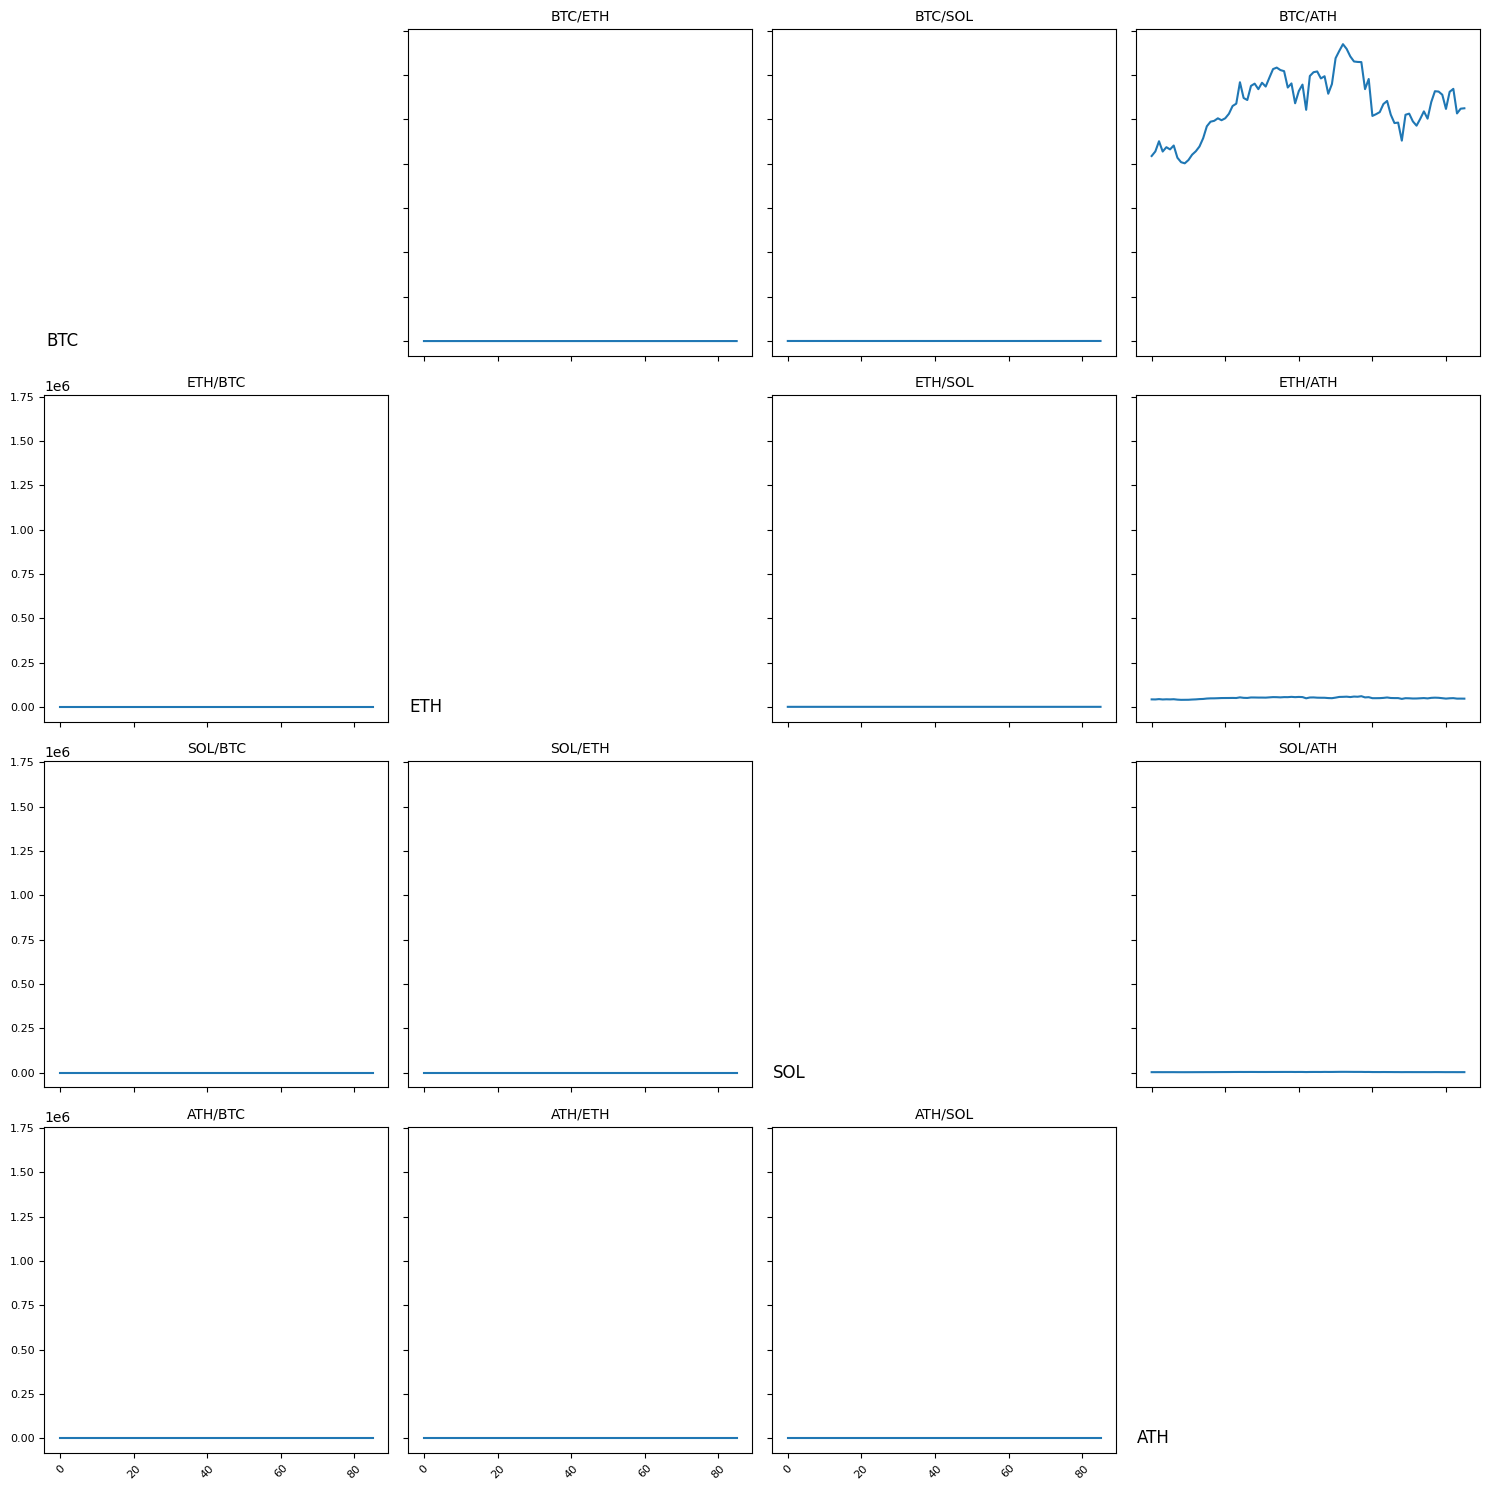

In [11]:
# Lunghezza della lista
N = len(symbols_list)

# Creazione della griglia di subplots
fig, axes = plt.subplots(N, N, figsize=(15, 15), sharex=True, sharey=True)

# Itera sui subplot e plotta i rapporti
for i, sym1 in enumerate(symbols_list):
    for j, sym2 in enumerate(symbols_list):
        ax = axes[i, j]
        
        if i == j:
            # Diagonale: nome della crypto
            ax.text(0.5, 0.5, sym1, fontsize=12, ha='center', va='center')
            ax.axis("off")
        else:
            # Rapporto tra sym1 e sym2
            ratio_col = f"{sym1}/{sym2}"
            if ratio_col in dati.columns:
                ax.plot(dati.index, dati[ratio_col], label=ratio_col)
                ax.set_title(ratio_col, fontsize=10)
        
        # Configura i ticks
        ax.tick_params(axis='x', labelrotation=45, labelsize=8)
        ax.tick_params(axis='y', labelsize=8)

# Aggiungi spaziatura e mostra il grafico
plt.tight_layout()
plt.show()